<a href="https://colab.research.google.com/github/khashayar-bo/CellParameter-Estimation/blob/main/ParameterEstimation_NLME_NTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports, Confiugrations and Functions

In [ ]:
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# This Class Stores the Data of the Cells

In [ ]:
class CellData:
  """
  This class stores the observed data from a cell
  """

  # This is the constructor for this class
  def __init__(self, cellDataframe, cellNum):
    self.mRNAData = cellDataframe.iloc[0:22,cellNum].to_numpy()
    self.darkData = cellDataframe.iloc[22:44,cellNum].to_numpy()
    self.fluoresentData = cellDataframe.iloc[44:66,cellNum].to_numpy()

  # This function returns the mRNA data
  def getmRNAData(self):
    return self.mRNAData.reshape(22, 1)

  # This function returns the dark protein data
  def getDarkProteinData(self):
    return self.darkData.reshape(22, 1)

  # This function returns the fluorescent data
  def getFluorescentData(self):
    return self.fluoresentData.reshape(22, 1)

  # This function returns all of the data together with a matrix
  def getCellData(self):
    mRNA = self.mRNAData.reshape(self.mRNAData.shape[0], 1)
    dark = self.darkData.reshape(self.darkData.shape[0], 1)
    fluorescent = self.fluoresentData.reshape(self.fluoresentData.shape[0], 1)
    finalData = np.append(mRNA, dark, axis=1)
    finalData = np.append(finalData, fluorescent, axis=1)

    return finalData

# This Class Contains the Optimizer Functions

In [ ]:
class Optimizer:
  """
  This class serves as the optimizer. It has some functions that upon calling 
  can further make progress in the optimizations
  """

  def __init__(self, t, boundarykrkp, boundarykdr, boundarykdp, boundarykm, cellData):
    self.t = t
    self.initializeBoundaries(boundarykrkp, boundarykdr, boundarykdp, boundarykm)
    self.currentResult = np.array([0.3, 0.04, 0.3, 0.007, 0.025])
    self.currentResult = np.append(self.currentResult, np.array([2,2,2,2,2,2,2,2,2]))
    self.previousResult = self.currentResult
    self.cellData = cellData
    self.predictedValues = None
  

  # This function contains the ODEs of the defined model
  def ODEs(self, x, t, kr, kdr, kp, kdp, km):
    # Assigning Values
    m = x[0]
    Pd = x[1]
    Pf = x[2]
  
    # Definig the ODEs
    dmdt = kr - kdr * m
    dPddt = kp * m - kdp * Pd - km * Pd
    dPfdt = km * Pd - kdp * Pf

    return [dmdt, dPddt, dPfdt]


  # The log likelihood function that should be minimized
  def logLikelihood(self, currentStatus):

    # Initialzing the sigma vectors
    sigma1 = np.ones((22, 1)) * currentStatus[5]
    sigma2 = np.ones((22, 1)) * currentStatus[6]
    sigma3 = np.ones((22, 1)) * currentStatus[7]
    sigma = np.concatenate((sigma1, sigma2, sigma3), axis=1)

    # Initializing the theta0 vector
    theta01 = np.ones((22, 1)) * currentStatus[8]
    theta02 = np.ones((22, 1)) * currentStatus[9]
    theta03 = np.ones((22, 1)) * currentStatus[10]
    theta0 = np.concatenate((theta01, theta02, theta03), axis=1)
    
    # Initializing theta1 vector
    theta11 = np.ones((22, 1)) * currentStatus[11]
    theta12 = np.ones((22, 1)) * currentStatus[12]
    theta13 = np.ones((22, 1)) * currentStatus[13]
    theta1 = np.concatenate((theta11, theta12, theta13), axis=1)


    predictedValues = odeint(self.ODEs, [0, 0, 0], t, args=(currentStatus[0], currentStatus[1], currentStatus[2], currentStatus[3], currentStatus[4],))
    self.predictedValues = predictedValues
    logLikelihoodValue = self.cellData.getCellData() - predictedValues
    logLikelihoodValue = np.divide(logLikelihoodValue, sigma)
    
    gVector = self.g(theta0, theta1, self.cellData.getCellData())
    logLikelihoodValue = np.divide(logLikelihoodValue, gVector)
    logLikelihoodValue = logLikelihoodValue ** 2
    logLikelihoodValue *= -0.5

    temporaryVector = np.multiply(sigma, gVector)
    temporaryVector = np.where(temporaryVector <= 0, 1, temporaryVector)

    logLikelihoodValue -= np.log(temporaryVector)
    
    return -1 * np.sum(logLikelihoodValue)

  # The g function which would model the noise
  def g(self, theta0, theta1, observedData):
    return theta0 + theta1 * observedData

  
  # This function optimizes the log-likelihood function with both parameters
  def optimizeLogLikelihood(self):
    self.previousResult = self.currentResult
    currentState = self.currentResult
    solution = minimize(self.logLikelihood, currentState, method='L-BFGS-B', bounds=self.bound, options={"maxiter":1000000, "maxfun":1000000})
    
    if solution['success'] == True:
      print("Holistic Optimization Successful")
      result = solution['x']

      self.currentResult = result

    else:
      print(solution)
      print("Holistic Optimization Failed")

  # This function only optimizes the Cell parameters
  def optimizeCellParameters(self):
    self.previousResult = self.currentResult
    
    # Lambda fucntion that only considers the cell parameters
    loglikCellParameters = lambda x: self.logLikelihood(np.concatenate((x, np.array([1, 1, 1, 1, 1, 1, 0, 0, 0]))))
    input = self.currentResult[0:5]
    solution = minimize(loglikCellParameters, input, method='L-BFGS-B', bounds=self.bound[0:5], options={"maxiter":1000000, "maxfun":1000000})

    if solution['success'] == True:
      print("Cell Parameter Only Optimization Successful")
      result = solution['x']

      self.currentResult[0:5] = result

    else:
      print("Cell Parameter Only Optimization Failed")

  # This function only optimizes the scale parameters
  def optimizeScaleParameters(self):
    self.previousResult = self.currentResult
    

    # Lambda fucntion that only considers the scale parameters
    loglikScaleParameters = lambda x: self.logLikelihood(np.append(np.array([self.currentResult[0], self.currentResult[1], self.currentResult[2], self.currentResult[3], self.currentResult[4]]), x))
    input = self.currentResult[5:]
    solution = minimize(loglikScaleParameters, input, method='L-BFGS-B', bounds=self.bound[5:], options={"maxiter":1000000, "maxfun":1000000})

    if solution['success'] == True:
      print("Scale Parameter Only Optimization Successful")
      result = solution['x']
      
      self.currentResult[5:] = result

    else:
      print("Scale Parameter Only Optimization Failed")

  # This function initilaizes the boundaries
  def initializeBoundaries(self, boundarykrkp, boundarykdr, boundarykdp, boundarykm):
    otherboundaries = (0.0001, 100000)
    bound = [boundarykrkp, boundarykdr, boundarykrkp, boundarykdp, boundarykm]
    for i in range(9):
      bound.append(otherboundaries)

    bound = tuple(bound)
    self.bound = bound

# Protocols for Optimization

In [ ]:
# Holisitc optimzation that optimizes all of the parameters simultaneously
def holisticOptimization(optimizerHolistic):
  while True:
    optimizerHolistic.optimizeLogLikelihood()
    if np.linalg.norm(optimizerHolistic.currentResult - optimizerHolistic.previousResult) < 0.001:
      break

# Iterative optimization
def iterativeOptimization(optimizerIterative):
  while True:
    optimizerIterative.optimizeCellParameters()
    savedResult = optimizerIterative.previousResult
    optimizerIterative.optimizeScaleParameters()

    if np.linalg.norm(savedResult - optimizerIterative.currentResult) < 0.0005:
      break

# Checking the functions for Cell1

In [ ]:
# Loading cell1 Data as a sample
cell1Data = CellData(pd.read_csv("data.csv"), 1)
# Initializing Time
t = np.array([0, 5])
t = np.append(t, np.arange(10, 201, 10))

# First the boundaries and the constraints are set
boundarykrkp = (0.001, 1)
boundarykdr = (0.035, 0.07)
boundarykdp = (0.005, 0.008)
boundarykm = (0.02, 0.03)

#Initializing the optimizer
optimizerHolistic1 = Optimizer(t, boundarykrkp, boundarykdr, boundarykdp, boundarykm, cell1Data)
optimizerIterative1 = Optimizer(t, boundarykrkp, boundarykdr, boundarykdp, boundarykm, cell1Data)

# This section optimizes all the parameters simultaneously
holisticOptimization(optimizerHolistic1)

# This section optimizes the parameters iteratively and seperately
iterativeOptimization(optimizerIterative1)

Holistic Optimization Successful
Holistic Optimization Successful
Cell Parameter Only Optimization Successful
Scale Parameter Only Optimization Successful


# Visulaizing the Results of Cell 1

In [ ]:
print("Iterative Method")
print(optimizerIterative1.currentResult)
print("Holistic Method")
print(optimizerHolistic1.currentResult)

Iterative Method
[0.56698866 0.05898061 0.33552215 0.00730124 0.02348478 0.07758702
 0.0649605  0.04019798 0.09633013 0.01558221 0.03736743 0.19528342
 0.37706394 0.34646475]
Holistic Method
[0.56300037 0.05853073 0.33257832 0.0071289  0.02333365 0.51596197
 0.0064679  0.41697439 0.01507616 0.15571465 0.00380929 0.02947485
 3.69007177 0.02488065]


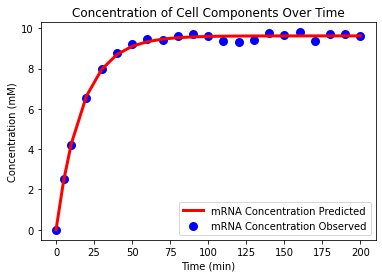

In [ ]:
t = np.array([0, 5])
t = np.append(t, np.arange(10, 201, 10))
plt.plot(t, optimizerHolistic.predictedValues[:,0], linewidth=3, color='red', label="mRNA Concentration Predicted")
plt.scatter(t, cell1Data.getmRNAData(), linewidth=3, color='blue', label="mRNA Concentration Observed")


plt.title("Concentration of Cell Components Over Time")
plt.xlabel("Time (min)")
plt.ylabel("Concentration (mM)")
plt.legend()
plt.show()

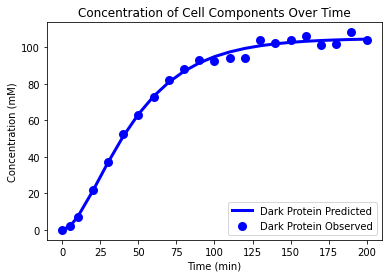

In [ ]:
plt.plot(t, optimizerHolistic.predictedValues[:,1], linewidth=3, color='blue', label="Dark Protein Predicted")
plt.scatter(t, cell1Data.getDarkProteinData(), linewidth=3, color='blue', label="Dark Protein Observed")

plt.title("Concentration of Cell Components Over Time")
plt.xlabel("Time (min)")
plt.ylabel("Concentration (mM)")
plt.legend()
plt.show()

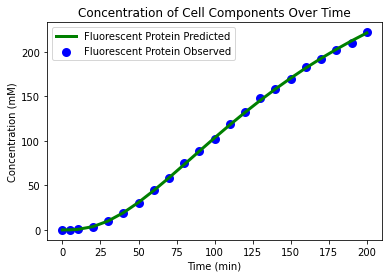

In [ ]:
plt.plot(t, optimizerHolistic.predictedValues[:,2], linewidth=3, color='green', label="Fluorescent Protein Predicted")
plt.scatter(t, cell1Data.getFluorescentData(), linewidth=3, color='blue', label="Fluorescent Protein Observed")

plt.title("Concentration of Cell Components Over Time")
plt.xlabel("Time (min)")
plt.ylabel("Concentration (mM)")
plt.legend()
plt.show()

# Drawing Subplots for the first 8 Cells

In [ ]:
# Reading the data of cell 2 to 8
for i in range(2, 9):
  globals()['cell%sData' % i] = CellData(pd.read_csv("data.csv"), i)

for i in range(2, 9):
  #Initializing the optimizer
  globals()["optimizerHolistic%s" % i] = Optimizer(t, boundarykrkp, boundarykdr, boundarykdp, boundarykm, globals()['cell%sData' % i])
  globals()["optimizerIterative%s" % i] = Optimizer(t, boundarykrkp, boundarykdr, boundarykdp, boundarykm, globals()['cell%sData' % i])
  holisticOptimization(globals()["optimizerHolistic%s" % i])
  iterativeOptimization(globals()["optimizerIterative%s" % i])


Holistic Optimization Successful
Holistic Optimization Successful
Holistic Optimization Successful
Holistic Optimization Successful
Cell Parameter Only Optimization Successful
Scale Parameter Only Optimization Successful
Holistic Optimization Successful
Holistic Optimization Successful
Cell Parameter Only Optimization Successful
Scale Parameter Only Optimization Successful
Holistic Optimization Successful
Holistic Optimization Successful
Cell Parameter Only Optimization Successful
Scale Parameter Only Optimization Successful
Holistic Optimization Successful
Holistic Optimization Successful
Cell Parameter Only Optimization Successful
Scale Parameter Only Optimization Successful
Holistic Optimization Successful
Holistic Optimization Successful
Holistic Optimization Successful
Holistic Optimization Successful
Cell Parameter Only Optimization Successful
Scale Parameter Only Optimization Successful
Holistic Optimization Successful
Holistic Optimization Successful
Cell Parameter Only Optimiz

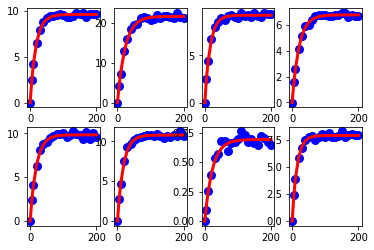

In [ ]:
for i in range(1, 9):
  # Plot i
  plt.subplot(2, 4, i)
  plt.plot(t, globals()["optimizerHolistic%s" % i].predictedValues[:,0], linewidth=3, color='red', label="mRNA Concentration Predicted")
  plt.scatter(t, globals()["cell%sData" % i].getmRNAData(), linewidth=3, color='blue', label="mRNA Concentration Observed")

plt.show()

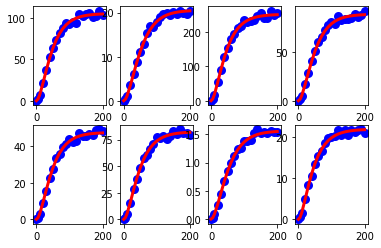

In [ ]:
for i in range(1, 9):
  # Plot i
  plt.subplot(2, 4, i)
  plt.plot(t, globals()["optimizerHolistic%s" % i].predictedValues[:,1], linewidth=3, color='red', label="mRNA Concentration Predicted")
  plt.scatter(t, globals()["cell%sData" % i].getDarkProteinData(), linewidth=3, color='blue', label="mRNA Concentration Observed")

plt.show()

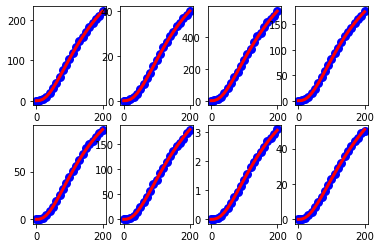

In [ ]:
for i in range(1, 9):
  # Plot i
  plt.subplot(2, 4, i)
  plt.plot(t, globals()["optimizerHolistic%s" % i].predictedValues[:,2], linewidth=3, color='red', label="mRNA Concentration Predicted")
  plt.scatter(t, globals()["cell%sData" % i].getFluorescentData(), linewidth=3, color='blue', label="mRNA Concentration Observed")

plt.show()